## Load data and corelation check

In [15]:
import pandas as pd
from config import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

df = pd.read_csv(CSV_FILEPATH_MODEL_READY_DATA)
display(df.head())

,price,vintage,designation_fe,winery_te,region_1_te,variety_te,province_te,country=Argentina,country=Armenia,country=Australia,...,taster_name=Matt Kettmann,taster_name=Michael Schachner,taster_name=Mike DeSimone,taster_name=Paul Gregutt,taster_name=Roger Voss,taster_name=Sean P. Sullivan,taster_name=Susan Kostrzewa,taster_name=Virginie Boone,taster_name=__MISSING__,points
0,NaN,2013.0,0.000008,88.098092,89.698917,87.362338,88.119743,0,0,0,...,0,0,0,0,0,0,0,0,0,87
1,15.0,2011.0,0.000015,87.904461,88.240848,88.842104,89.150171,0,0,0,...,0,0,0,0,1,0,0,0,0,87
2,14.0,2013.0,0.288257,88.157790,89.057677,88.497045,89.036889,0,0,0,...,0,0,0,1,0,0,0,0,0,87
3,13.0,2013.0,0.000062,87.026188,86.215713,89.441728,86.254714,0,0,0,...,0,0,0,0,0,0,0,0,0,87
4,65.0,2012.0,0.000008,87.556592,89.109913,89.403383,89.042131,0,0,0,...,0,0,0,1,0,0,0,0,0,87


In [16]:
display("missing values in each column in percent:")
missing_percent = (df.isna().sum() / len(df)) * 100
display(missing_percent[missing_percent > 0])
display("missing values in each column in count:")
missing_count = df.isna().sum()
display(missing_count[missing_count > 0])
display(f"Number of rows where both 'price' and 'vintage' are missing: {df[df['price'].isna() & df['vintage'].isna()].shape[0]}")

'missing values in each column in percent:'

price      6.921544
vintage    3.563103
dtype: float64

'missing values in each column in count:'

price      8996
vintage    4631
dtype: int64

"Number of rows where both 'price' and 'vintage' are missing: 476"

In [17]:
# first we need to drop rows where 'price' or 'vintage' is missing, because these are crucial for our analysis and model
df_without_missing_price_and_vintage = df.dropna(subset=['price', 'vintage'])

### Corelation check

#### Corelation values

In [18]:
corelation_threshold = 0.05

correlations = df_without_missing_price_and_vintage.corr()['price'].sort_values(ascending=False)
correlations = correlations.drop('price', errors='ignore')

pd.set_option('display.max_rows', None)
correlations_df = correlations.to_frame(name='Correlation')
correlations_df = correlations_df[correlations_df['Correlation'].abs() > corelation_threshold]
realiable_features = correlations_df.index.tolist()

display(len(realiable_features), correlations_df)
pd.reset_option('display.max_rows')

11

,Correlation
points,0.414945
winery_te,0.345040
region_1_te,0.334312
variety_te,0.208549
province_te,0.189434
taster_name=Virginie Boone,0.081293
taster_name=Kerin O’Keefe,0.050896
country=Chile,-0.070608
designation_fe,-0.085747
taster_name=Michael Schachner,-0.091987


#### Corelation plots

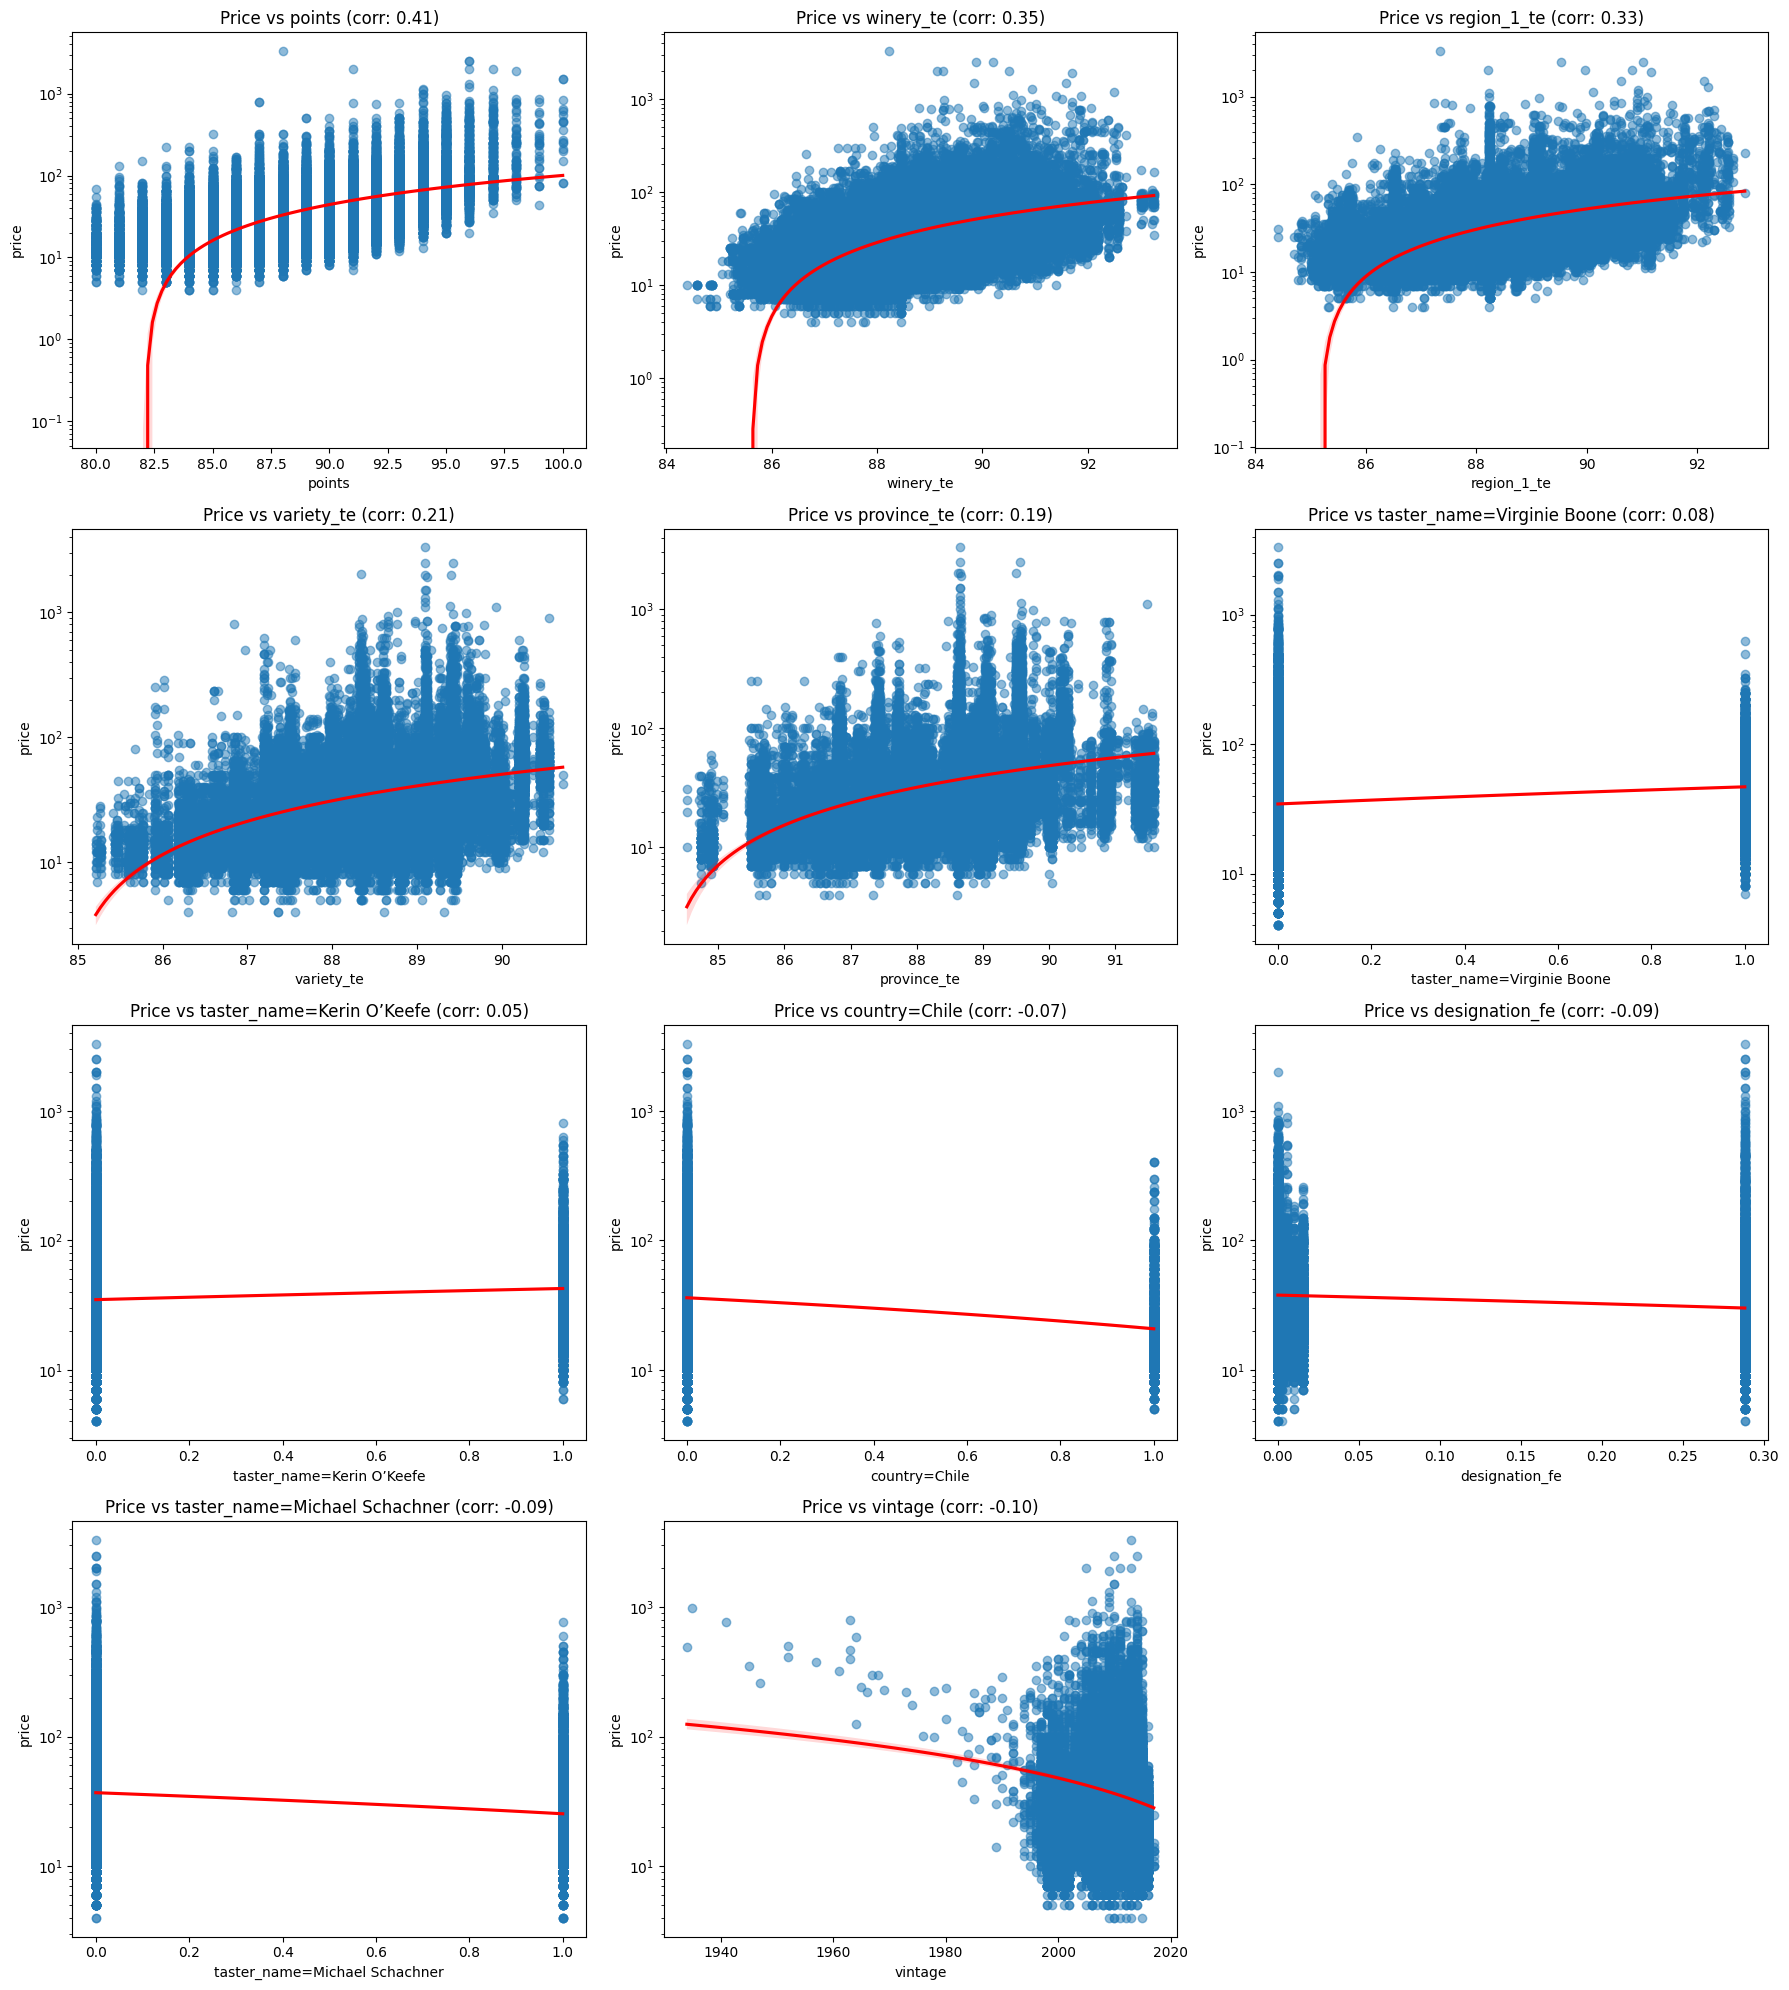

In [19]:
n_cols = 3
n_rows = math.ceil(len(realiable_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(realiable_features):
    plot = sns.regplot(
        x=col,
        y='price',
        data=df_without_missing_price_and_vintage,
        ax=axes[i],
        scatter_kws={'alpha':0.5}, 
        line_kws={'color': 'red'} 
    )
    
    axes[i].set_yscale('log')
    axes[i].set_title(f"Price vs {col} (corr: {correlations[col]:.2f})")

# Ukrywamy puste wykresy
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

The scatter plots illustrate the relationship between various features and price. Notably, vintage exhibits a negligible correlation (~ -0.1), suggesting that for this market, an item’s premium status carries more weight than its age or 'vintage' year.

# Using Linear Regression to predict price

## Without embeddings

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split